In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
# Define the custom color palette
colors = {
    "blue_20": "#D1E4F1",
    "blue_40": "#A3CAE3",
    "blue_80": "#4695C8",
    "blue": "#187ABA",
    "navy_20": "#CCD5DC",
    "navy_40": "#99AAB9",
    "navy_80": "#335574",
    "navy": "#002B51"
}
data = pd.read_csv('./tiszta_lakik.csv')
data['price/area'] = data['price']/data['area']
data.columns

Index(['Unnamed: 0', 'location', 'property_type', 'price', 'area', 'rooms',
       'condition', 'year_of_construction', 'comfort', 'floor',
       'building_levels', 'description', 'elevator', 'ceiling_height',
       'air_conditioning', 'accessible', 'balcony_size', 'parking',
       'parking_price', 'energy_certificate', 'avg_gas_consumption',
       'avg_electricity_consumption', 'maintenance_costs',
       'maintenance_cost_details', 'common_costs', 'common_cost_details',
       'heating', 'insulation', 'project_name', 'project_completion_date',
       'number_of_apartments', 'price_range', 'price_range_bottom',
       'price_range_top', 'area_range', 'area_range_bottom', 'area_range_top',
       'developer', 'nearby_universities', 'nearby_schools',
       'public_transport_nearby', 'historical_note', 'district', 'street',
       'price_per_area', 'lat', 'lng', 'price/area'],
      dtype='object')

In [409]:
result = data.groupby('district')['price_per_area'].mean()
import geopandas as gpd

# Load the geospatial data from the provided path
gdf_districts = gpd.read_file('./districts/gdf_districts.shp')
gdf_districts.head()

,place_name,bbox_north,bbox_south,bbox_east,bbox_west,geometry
0,"1st district, Budapest, Central Hungary, Hungary",47.508081,47.485671,19.051307,19.023778,"POLYGON ((19.02378 47.49568, 19.02380 47.49619..."
1,"2nd district, Budapest, Central Hungary, Hungary",47.578906,47.506060,19.042713,18.925106,"POLYGON ((18.92511 47.54414, 18.92919 47.54560..."
2,"3rd district, Budapest, Central Hungary, Hungary",47.610094,47.526869,19.076146,18.976838,"POLYGON ((18.97684 47.57484, 18.97751 47.57575..."
3,"4th district, Budapest, Central Hungary, Hungary",47.613147,47.542325,19.123463,19.067197,"POLYGON ((19.06720 47.56314, 19.06741 47.56360..."
4,"5th district, Budapest, Central Hungary, Hungary",47.514747,47.485786,19.061780,19.042022,"POLYGON ((19.04202 47.51471, 19.04332 47.51475..."


In [432]:
import pandas as pd
import geopandas as gpd
import folium
import re
from folium.features import DivIcon

# Load the district shapefile
gdf_districts = gpd.read_file('./districts/gdf_districts.shp')

# Standardize the district column in the GeoDataFrame to extract the district number
# For example, converting "1st district, Budapest" to "I"
gdf_districts['district_number'] = gdf_districts['place_name'].apply(
    lambda x: re.findall(r'(\d+)', x)[0] if re.findall(r'(\d+)', x) else None
)

# Extract district Roman numerals from your result data (like "Budapest I. kerület" -> "I")
result = data.groupby('district')['price_per_area'].mean().reset_index()
result['district_number'] = result['district'].apply(lambda x: re.findall(r'([IVXLCDM]+)', x)[0])

# Map Roman numerals to Arabic numerals for merging
roman_to_arabic = {
    'I': '1', 'II': '2', 'III': '3', 'IV': '4', 'V': '5', 'VI': '6',
    'VII': '7', 'VIII': '8', 'IX': '9', 'X': '10', 'XI': '11', 'XII': '12',
    'XIII': '13', 'XIV': '14', 'XV': '15', 'XVI': '16', 'XVII': '17', 'XVIII': '18',
    'XIX': '19', 'XX': '20', 'XXI': '21', 'XXII': '22', 'XXIII': '23'
}
result['district_number'] = result['district_number'].map(roman_to_arabic)

# Merge the dataframes on the district number
merged = gdf_districts.merge(result, on='district_number', how='left')

# Create a Folium map centered around Budapest
m = folium.Map(location=[47.4979, 19.1402], zoom_start=11)

# Add the choropleth layer
folium.Choropleth(
    geo_data=merged,
    name="choropleth",
    data=merged,
    columns=['district_number', 'price_per_area'],
    key_on="feature.properties.district_number",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.9,
    legend_name="Price per Area",
).add_to(m)

# Add district labels with average prices at the centroid of each district
for _, row in merged.iterrows():
    # Get the centroid of the district polygon
    centroid = row['geometry'].centroid
    # Add the label to the map
    folium.map.Marker(
        [centroid.y, centroid.x],
        icon=DivIcon(
            icon_size=(150, 36),
            icon_anchor=(+10, +10),
html=f'<div style="font-size: 8pt; color: black; font-weight:bold">{float(row["price_per_area"])/1e6:.2f}M</div>',
        )
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map to an HTML file
m.save('budapest_price_per_area_with_labels.html')

# Display the map in the notebook (if using Jupyter)
m


Plot saved as ./terulet_eloszlas.svg


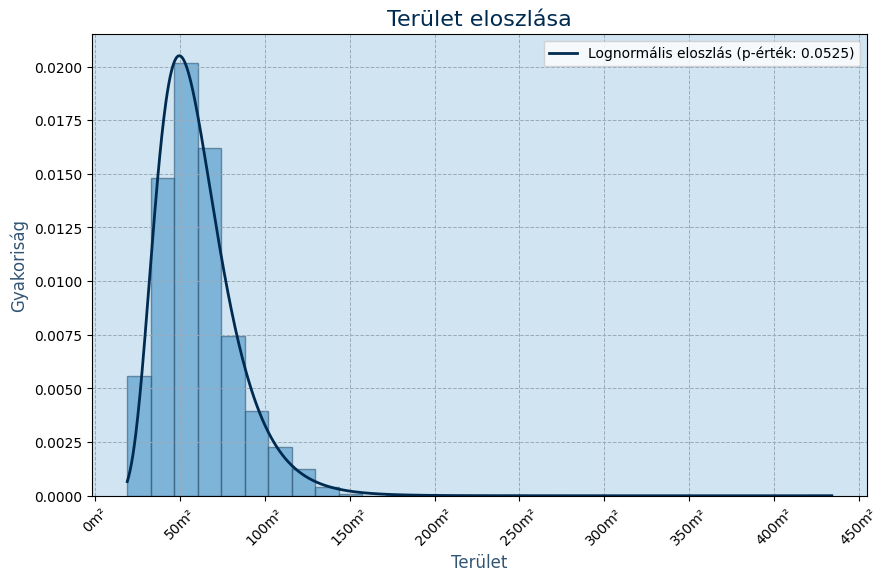

In [372]:
# Generalized function to fit distributions (Gamma and Log-Normal) to any column and save as PNG if specified

def plot_distribution_with_fit(column, column_name_hu, save_path=None):
    # Remove NaN values from the selected data column
    data_column = data[column].dropna()

    # Fit Gamma and Log-Normal distributions
    gamma_params = stats.gamma.fit(data_column)
    lognorm_params = stats.lognorm.fit(data_column, floc=0)

    # Generate x values for plotting the fitted distributions
    x = np.linspace(data_column.min(), data_column.max(), 1000)

    # Get the Gamma and Log-Normal probability density functions
    gamma_pdf = stats.gamma.pdf(x, *gamma_params)
    lognorm_pdf = stats.lognorm.pdf(x, *lognorm_params)

    # Perform statistical tests to get p-values
    gamma_ks_test = stats.kstest(data_column, 'gamma', args=gamma_params)
    lognorm_ks_test = stats.kstest(data_column, 'lognorm', args=lognorm_params)

    # Determine which distribution fits better based on the p-value
    if gamma_ks_test.pvalue > lognorm_ks_test.pvalue:
        best_fit_label = "Gamma"
        best_pdf = gamma_pdf
        p_value = gamma_ks_test.pvalue
    else:
        best_fit_label = "Lognormális"
        best_pdf = lognorm_pdf
        p_value = lognorm_ks_test.pvalue

    # Plot the histogram of the selected column
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(data_column, bins=30, density=True, color=colors['blue_80'], edgecolor=colors['navy_80'], alpha=0.6)

    # Overlay the best-fit distribution
    ax.plot(x, best_pdf, color=colors['navy'], label=f'{best_fit_label} eloszlás (p-érték: {p_value:.4f})', linewidth=2)

    # Set the background color
    ax.set_facecolor(colors['blue_20'])

    # Customize grid and labels in Hungarian
    ax.grid(True, color=colors['navy_40'], linestyle='--', linewidth=0.7)
    ax.set_title(f'{column_name_hu} eloszlása', fontsize=16, color=colors['navy'])
    ax.set_xlabel(f'{column_name_hu}', fontsize=12, color=colors['navy_80'])
    ax.set_ylabel('Gyakoriság', fontsize=12, color=colors['navy_80'])
    
    if column_name_hu=="Terület":
        ticks = np.arange(0, data_column.max() + 50, 50)  # Create tick values at intervals of 50
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{int(tick)}m²" for tick in ticks], rotation=45)
    elif column_name_hu=="Ár":
        ticks = np.arange(20000000, data_column.max() + 10000000, 10000000)  # Create tick values at intervals of 50
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{int(tick)//1000000}M" for tick in ticks], rotation=45)
    elif column_name_hu=="Négyzetméterár":
        ticks = np.arange(0, data_column.max(), 300000)  # Create tick values at intervals of 50
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{int(tick)/1000000}M" for tick in ticks], rotation=45)
    # Show legend
    ax.legend()

    # Save plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()

# Example of using this function to plot 'area' (Terület) and save it
plot_distribution_with_fit('area', 'Terület', save_path='./terulet_eloszlas.svg')


Plot saved as ./terulet_eloszlas.svg


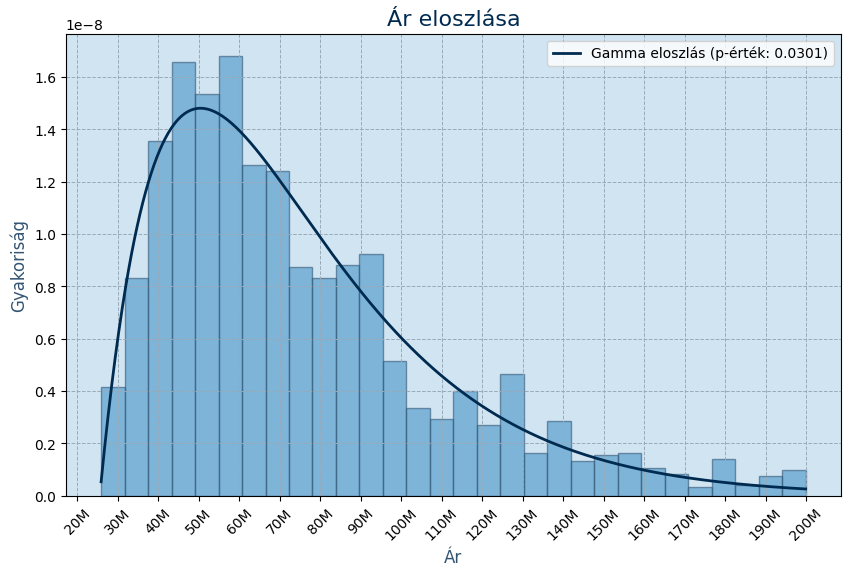

In [373]:
plot_distribution_with_fit('price', 'Ár', save_path='./terulet_eloszlas.svg')


Plot saved as ./terulet_eloszlas.svg


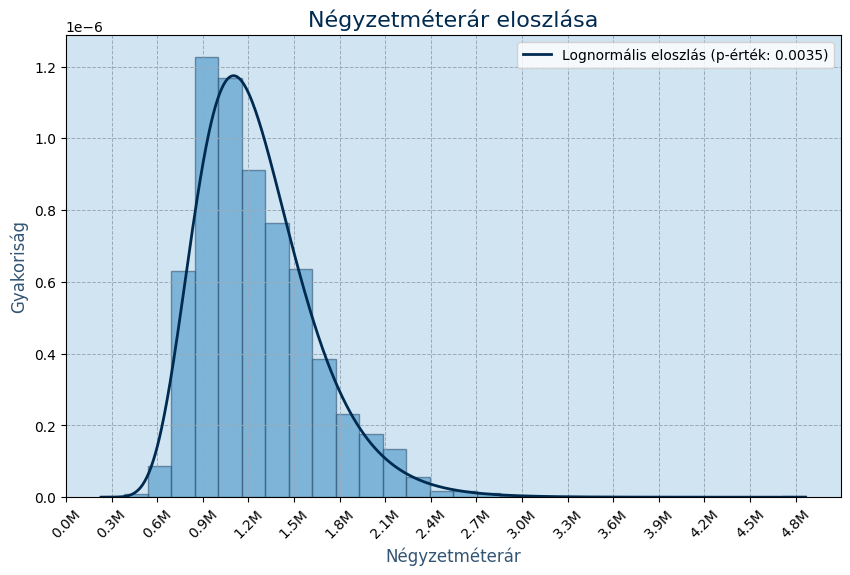

In [374]:
plot_distribution_with_fit('price/area', 'Négyzetméterár', save_path='./terulet_eloszlas.svg')


Plot saved as ./price_area_scatter.png


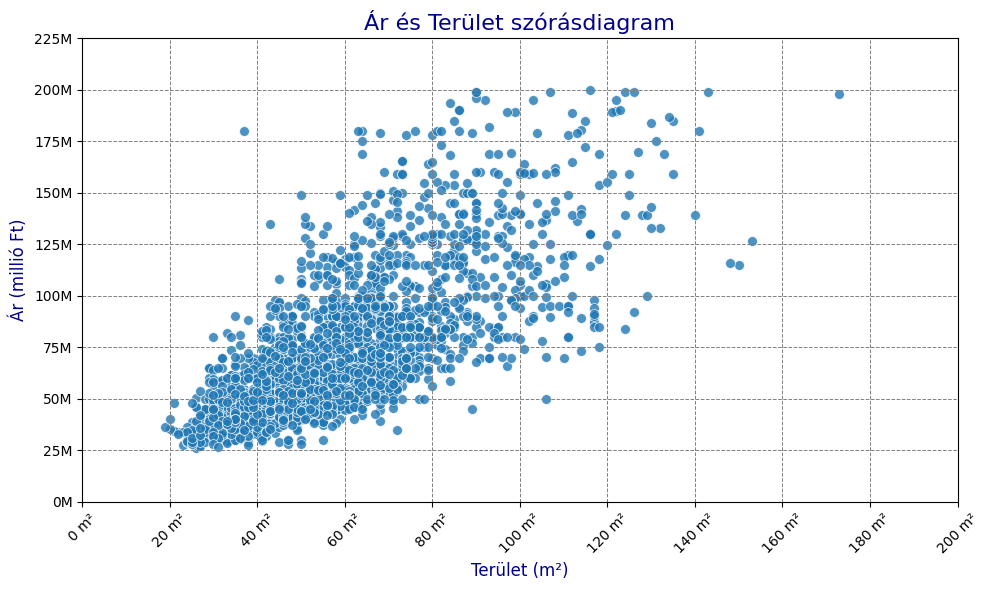

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generalized function to plot a scatter plot with x, y, and optional color, and a customizable title
def plot_scatter_with_color(data, x_column, y_column, color_column=None, title_hu='', x_label=None, y_label=None, save_path=None):
    # Remove NaN values from the selected columns
    columns = [x_column, y_column] + ([color_column] if color_column else [])
    data_clean = data[columns].dropna()

    # Set up the figure and scatter plot
    plt.figure(figsize=(10, 6))
    
    # Create a scatter plot using Seaborn
    if color_column:
        scatter_plot = sns.scatterplot(
            data=data_clean,
            x=x_column,
            y=y_column,
            hue=color_column,
            palette="coolwarm",
            edgecolor='w',
            s=50,  # size of the points
            alpha=0.8  # transparency of points
        )
    else:
        scatter_plot = sns.scatterplot(
            data=data_clean,
            x=x_column,
            y=y_column,
            edgecolor='w',
            s=50,  # size of the points
            alpha=0.8  # transparency of points
        )

    # Customize the plot
    scatter_plot.set_title(title_hu, fontsize=16, color='darkblue')
    
    # Set custom labels for x and y axes, falling back to column names if none provided
    scatter_plot.set_xlabel(x_label if x_label else x_column, fontsize=12, color='darkblue')
    scatter_plot.set_ylabel(y_label if y_label else y_column, fontsize=12, color='darkblue')

    # Adjust x-ticks and y-ticks if needed for 'area' (keeping it in m², no conversion)
    if x_column == 'area':
        # Generate ticks with a step of 20 m²
        x_min, x_max = data_clean[x_column].min(), data_clean[x_column].max()
        ticks = np.arange(0, x_max + 20, 20)
        scatter_plot.set_xticks(ticks)
        scatter_plot.set_xticklabels([f"{int(tick)} m²" for tick in ticks], rotation=45)


    if y_column == 'price':
        ticks = plt.gca().get_yticks()
        scatter_plot.set_yticks(ticks)
        scatter_plot.set_yticklabels([f"{int(tick)//1000000}M" for tick in ticks])

    # Show legend if color_column is provided
    if color_column:
        scatter_plot.legend(title=color_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Customize grid
    scatter_plot.grid(True, color='gray', linestyle='--', linewidth=0.7)
    scatter_plot.set_xlim([0,200])
    # Save plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {save_path}")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example of using this function to plot 'price' vs 'area' without color
plot_scatter_with_color(
    data, 
    'area', 
    'price', 
    color_column=None,  # Pass None if no color is needed
    title_hu='Ár és Terület szórásdiagram', 
    x_label='Terület (m²)', 
    y_label='Ár (millió Ft)',
    save_path='./price_area_scatter.png'
)


In [376]:
interesting_columns = ["property_type", "price", "area", "rooms", 
 "condition", "year_of_construction", "comfort",
 "floor", "building_levels", "elevator", "air_conditioning",
 "accessible", "balcony_size", "parking", "energy_certificate",
 "heating", "district", "street", "lat", "lng"]
target = "price"
df= data[interesting_columns]
Y = df[target]
X = df.drop(columns=[target])



In [377]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for a DataFrame
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Function to detect log-normal numerical columns and apply log transformation
def identify_lognormal_columns(X, numerical_cols, threshold=0.05):
    lognormal_cols = []
    for col in numerical_cols:
        # Avoid applying log to negative values
        if (X[col] > 0).all():
            # Test if the log-transformed column is more normally distributed
            transformed = np.log1p(X[col])
            stat, p_value = normaltest(transformed)
            # If the p-value of the normality test is above the threshold, we consider it approximately normal
            if p_value > threshold:
                lognormal_cols.append(col)
    return lognormal_cols

# Preprocessing function with log normalization and VIF calculation
def preprocess_data_with_vif(X, vif_threshold=5):
    # Convert boolean columns to strings to avoid type mismatch during encoding
    X = X.applymap(lambda x: str(x) if isinstance(x, bool) else x)
    
    # Automatically identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    print(f"Numeric columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Identify log-normal columns
    lognormal_cols = identify_lognormal_columns(X, numerical_cols)
    print(f"Log-normal columns: {lognormal_cols}")

    # Apply log transformation to log-normal columns
    X[lognormal_cols] = np.log1p(X[lognormal_cols])

    # Pipeline for numerical columns: Fill missing values with 0 and scale
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill NaNs with 0
        ('scaler', StandardScaler())  # Standardize numerical values
    ])

    # Pipeline for categorical columns: Fill missing with '0' and apply OneHotEncoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='0')),  # Fill NaNs with '0'
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHotEncoding for categorical variables
    ])

    # Combine both pipelines into a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Apply transformations
    X_clean = preprocessor.fit_transform(X)

    # Combine transformed numerical and categorical columns into a DataFrame
    X_clean_df = pd.DataFrame(X_clean, columns=numerical_cols.tolist() + 
                              list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)))


    
    return X_clean_df

# Example usage
X_clean_df= preprocess_data_with_vif(X, vif_threshold=5)

# Scaling Y (target)
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# Initialize the PowerTransformer (Yeo-Johnson by default)
# scaler_Y = PowerTransformer(method='box-cox', standardize=False)

# scaler_Y = PowerTransformer(method='yeo-johnson')
scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X_clean_df, Y_scaled, test_size=0.2, random_state=42)



Numeric columns: Index(['area', 'rooms', 'year_of_construction', 'floor', 'building_levels',
       'balcony_size', 'lat', 'lng'],
      dtype='object')
Categorical columns: Index(['property_type', 'condition', 'comfort', 'elevator', 'air_conditioning',
       'accessible', 'parking', 'energy_certificate', 'heating', 'district',
       'street'],
      dtype='object')
Log-normal columns: ['area']


C:\Users\takat\AppData\Local\Temp\ipykernel_22600\2777603081.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x) if isinstance(x, bool) else x)


In [378]:
def evaluate_model(model, X_test, Y_test, scaler_Y):
    Y_pred_scaled = np.array(model.predict(X_test))
    Y_pred_original = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1))
    Y_test_original = scaler_Y.inverse_transform(Y_test)

    mse = mean_squared_error(Y_test_original, Y_pred_original)
    mae = mean_absolute_error(Y_test_original, Y_pred_original)
    r2 = r2_score(Y_test_original, Y_pred_original)
    evs = explained_variance_score(Y_test_original, Y_pred_original)
    rel_error = np.mean(np.abs((Y_test_original - Y_pred_original) / Y_test_original)) * 100

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Explained Variance Score: {evs}")
    print(f"Relative Error: {rel_error:.2f}%")

    return rel_error

In [379]:
model = XGBRegressor(random_state=42)


In [380]:
def drop_worst_features(X, Y, model, min_features=9):
    remaining_features = X.columns.tolist()
    iteration = 1
    
    while len(remaining_features) > min_features:
        print(f"\nIteration {iteration}: Training with {len(remaining_features)} features.")
        
        # Train the model
        model.fit(X[remaining_features], Y.ravel())
        
        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
        else:
            raise ValueError("Model does not provide feature importances or coefficients.")
        
        # Sort features by importance and drop the worst 20%
        n_drop = max(1, int(0.2 * len(remaining_features)))  # Drop at least 1 feature
        sorted_features = np.argsort(importances)
        worst_features = [remaining_features[i] for i in sorted_features[:n_drop]]
        remaining_features = [f for f in remaining_features if f not in worst_features]
        
        # Fit the model on remaining features and evaluate
        model.fit(X[remaining_features], Y.ravel())
        evaluate_model(model, X_test[remaining_features], Y_test, scaler_Y)
        
        iteration += 1

    print(f"\nFinal iteration with {len(remaining_features)} features.")
    return remaining_features

# Run feature dropping process
final_features = drop_worst_features(X_train, Y_train, model, min_features=10)
# final_features = ['area',
#  'year_of_construction',
#  'property_type_Eladó panel lakás',
#  'property_type_Eladó tégla lakás',
#  'condition_közepes állapotú',
#  'condition_újszerű',
#  'comfort_luxus',
#  'heating_gáz (konvektor)',
#  'district_Budapest V. kerület',
#  'district_Budapest XXI. kerület']
X_train, X_test =X_train[final_features], X_test[final_features]



Iteration 1: Training with 1687 features.
Mean Squared Error (MSE): 168082552876484.56
Mean Absolute Error (MAE): 8783525.271867612
R^2 Score: 0.8433765142015572
Explained Variance Score: 0.8433804088590933
Relative Error: 11.49%

Iteration 2: Training with 1350 features.
Mean Squared Error (MSE): 168082552876484.56
Mean Absolute Error (MAE): 8783525.271867612
R^2 Score: 0.8433765142015572
Explained Variance Score: 0.8433804088590933
Relative Error: 11.49%

Iteration 3: Training with 1080 features.
Mean Squared Error (MSE): 168082552876484.56
Mean Absolute Error (MAE): 8783525.271867612
R^2 Score: 0.8433765142015572
Explained Variance Score: 0.8433804088590933
Relative Error: 11.49%

Iteration 4: Training with 864 features.
Mean Squared Error (MSE): 168082552876484.56
Mean Absolute Error (MAE): 8783525.271867612
R^2 Score: 0.8433765142015572
Explained Variance Score: 0.8433804088590933
Relative Error: 11.49%

Iteration 5: Training with 692 features.
Mean Squared Error (MSE): 168082552

                           Feature  Importance
7     heating_padlófűtés, falfűtés    0.245210
8     district_Budapest V. kerület    0.175657
6                    comfort_luxus    0.138733
0                             area    0.116556
4  property_type_Eladó tégla lakás    0.112648
9              street_ Andrássy út    0.052242
2                     balcony_size    0.049167
3  property_type_Eladó panel lakás    0.039757
1             year_of_construction    0.037491
5            condition_felújítandó    0.032540


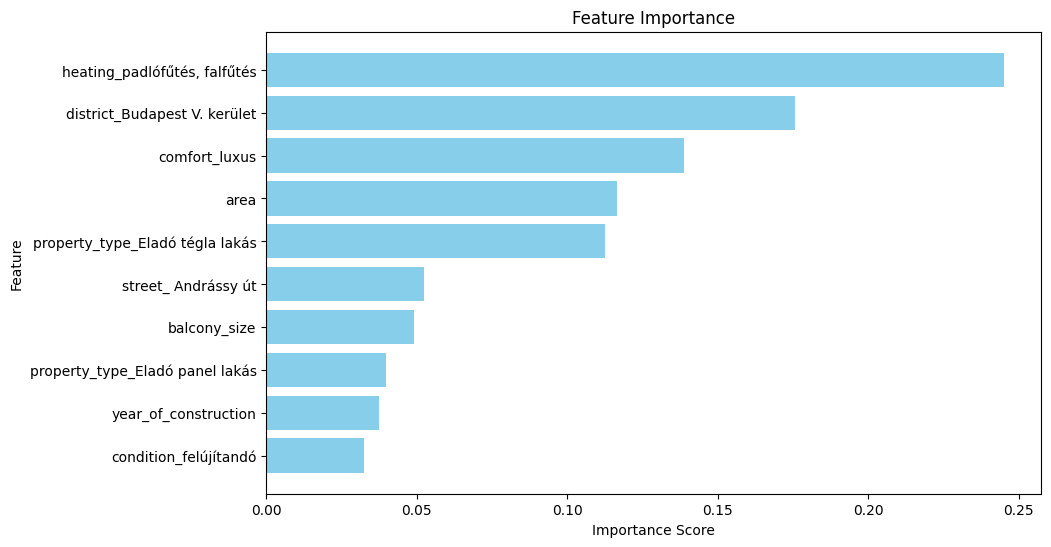

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

model.fit(X_train, Y_train.ravel())

# Get feature importances
importances = model.feature_importances_
feature_names = final_features

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


In [382]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Fit a linear regression model using statsmodels
def fit_linear_regression_statsmodels(X_train, Y_train, X_test, Y_test, scaler_Y):
    # Add a constant (intercept) to the model
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # Fit the OLS (Ordinary Least Squares) model
    model = sm.OLS(Y_train, X_train_const)
    results = model.fit()
    evaluate_model(results, X_test_const, Y_test, scaler_Y)


# Fit the model with final features and evaluate
fit_linear_regression_statsmodels(X_train, Y_train,X_test,Y_test, scaler_Y)


Mean Squared Error (MSE): 363347966806414.5
Mean Absolute Error (MAE): 14213858.851499775
R^2 Score: 0.6614233652149671
Explained Variance Score: 0.6614233823103542
Relative Error: 21.02%


In [383]:
X_train.isna().any().any()

False

In [384]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def fit_and_evaluate_model(model, params, X_train, Y_train, X_test, Y_test, scaler_Y=None):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {model.__class__.__name__}: {grid_search.best_params_}")
    
    rel_error = evaluate_model(best_model, X_test, Y_test, scaler_Y)
    return best_model, rel_error

models_with_params = [
    (LinearRegression(), {}),
    (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    (Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [3, 5, 10]}),
    (GradientBoostingRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
]

best_model = None
best_error = float('inf')

for model, params in models_with_params:
    _, rel_error = fit_and_evaluate_model(model, params, X_train, Y_train, X_test, Y_test, scaler_Y)
    
    if rel_error < best_error:
        best_error = rel_error
        best_model = model

print(f"Best model based on Relative Error: {best_model.__class__.__name__} with Relative Error: {best_error:.2f}%")

Best hyperparameters for LinearRegression: {}
Mean Squared Error (MSE): 363347966806414.5
Mean Absolute Error (MAE): 14213858.851499775
R^2 Score: 0.6614233652149671
Explained Variance Score: 0.6614233823103544
Relative Error: 21.02%
Best hyperparameters for Ridge: {'alpha': 1.0}
Mean Squared Error (MSE): 363658959967145.75
Mean Absolute Error (MAE): 14219167.269357568
R^2 Score: 0.6611335740851942
Explained Variance Score: 0.6611353710323828
Relative Error: 21.03%
Best hyperparameters for Lasso: {'alpha': 0.1}
Mean Squared Error (MSE): 801410021707045.5
Mean Absolute Error (MAE): 22559997.907599468
R^2 Score: 0.2532262926432277
Explained Variance Score: 0.25474213892281816
Relative Error: 34.00%


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best hyperparameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 200}
Mean Squared Error (MSE): 320646545083977.1
Mean Absolute Error (MAE): 12723186.06613651
R^2 Score: 0.7012136075944495
Explained Variance Score: 0.7020834311777546
Relative Error: 17.80%


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'n_estimators': 100}
Mean Squared Error (MSE): 295606026109272.75
Mean Absolute Error (MAE): 12497482.088999612
R^2 Score: 0.7245469833726141
Explained Variance Score: 0.7249537814209509
Relative Error: 17.59%
Best hyperparameters for SVR: {'C': 1, 'kernel': 'rbf'}
Mean Squared Error (MSE): 308122076394912.7
Mean Absolute Error (MAE): 12818758.934863247
R^2 Score: 0.7128842177219399
Explained Variance Score: 0.7130794490311367
Relative Error: 18.50%
Best model based on Relative Error: GradientBoostingRegressor with Relative Error: 17.59%


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


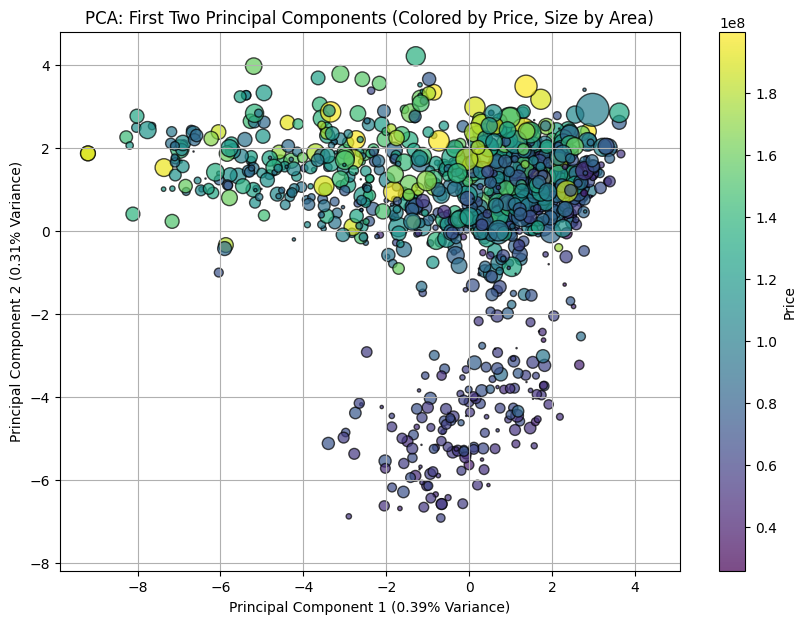

In [385]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Scale the features (if not already scaled)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean_df)

# 2. Apply PCA to reduce to 2 components (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Explained variance ratio for the components
explained_variance = pca.explained_variance_ratio_

# 4. Use 'price' as the dynamic parameter for coloring
price = Y  # Assuming 'Y' contains the price values
area = X_clean_df['area']  # Assuming 'area' is one of the features

# 5. Plot the first two principal components
# Size of points depends on 'area', color depends on 'price'
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=price, s=area*100, cmap='viridis', alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Price')
plt.title('PCA: First Two Principal Components (Colored by Price, Size by Area)')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.grid(True)
plt.show()



In [386]:
interesting_columns = ["price/area","lat", "lng"]
target = "price/area"

df_geo= data[interesting_columns]
df_geo= df_geo.dropna()
Y_pm = df_geo[target]
X_pm = df_geo.drop(columns=[target])


In [387]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import StandardScaler

# # Prepare grid for heatmap
# def generate_grid(X_pm, num=100):
#     lat_min, lat_max = X_pm['lat'].quantile(0.02), X_pm['lat'].quantile(0.98)

#     # lat_min, lat_max = X_pm['lat'].percentile(20), X_pm['lat'].percentile(98)
#     lng_min, lng_max = X_pm['lng'].quantile(0.02), X_pm['lng'].quantile(0.98)

#     # lng_min, lng_max = X_pm['lng'].min(), X_pm['lng'].max()
    
#     lat_grid = np.linspace(lat_min, lat_max, num)
#     lng_grid = np.linspace(lng_min, lng_max, num)
    
#     lat_lng_grid = np.array(np.meshgrid(lat_grid, lng_grid)).T.reshape(-1, 2)
#     return lat_grid, lng_grid, lat_lng_grid

# # Function to randomly sample and fit models
# def sample_fit_and_predict(X_pm, Y_pm, grid, num_iterations=10, sample_size=0.8):
#     predictions = []
    
#     for _ in range(num_iterations):
#         # Randomly sample 80% of the data
#         sample_indices = np.random.choice(X_pm.index, size=int(len(X_pm) * sample_size), replace=False)
#         X_sample = X_pm.loc[sample_indices]
#         Y_sample = Y_pm.loc[sample_indices]

#         # Fit MLPRegressor
#         model = MLPRegressor(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=2000)
#         scaler = StandardScaler()
#         X_sample_scaled = scaler.fit_transform(X_sample)
        
#         model.fit(X_sample_scaled, Y_sample)

#         # Predict on the grid
#         grid_scaled = scaler.transform(grid)
#         predictions.append(model.predict(grid_scaled))
    
#     # Return average predictions over all models
#     return np.mean(predictions, axis=0)

# # Generate grid
# lat_grid, lng_grid, lat_lng_grid = generate_grid(X_pm)

# # Fit and predict on the grid for 10 iterations of random sampling
# predictions = sample_fit_and_predict(X_pm, Y_pm, lat_lng_grid, num_iterations=100)

# # Reshape predictions to match the grid
# predictions_grid = predictions.reshape(len(lat_grid), len(lng_grid))


# # Plot heatmap
# plt.figure(figsize=(10, 8))
# plt.contourf(lng_grid, lat_grid, predictions_grid, cmap='coolwarm')
# # plt.scatter( df_geo['lng'],df_geo['lat'], c=Y_pm)
# plt.colorbar(label='Predicted price/area')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Ensemble MLP Neural Network Predictions Heatmap')
# plt.show()

In [388]:

# # Assuming 'final_features' contains the final selected feature names after dropping the worst one

# import statsmodels.api as sm
# import numpy as np

# def fit_linear_regression_statsmodels(X, Y, significance_level=0.05):
#     # Add a constant (intercept) to the model
#     X_with_const = sm.add_constant(X)
    
#     # Fit the OLS (Ordinary Least Squares) model
#     model = sm.OLS(Y, X_with_const)
#     results = model.fit()

#     # Print out the summary which includes p-values and coefficients
#     print(results.summary())
    
#     # Calculate residuals (actual - predicted)
#     Y_pred = np.array(results.predict(X_with_const))
#     residuals = np.array(Y).reshape(-1) - np.array(Y_pred).reshape(-1)
    
#     return results, residuals

# def iterative_feature_removal(X, Y, significance_level=0.05):
#     X_iter = X.copy()  # Start with a copy of the dataset
#     while True:
#         # Fit the model and get results
#         results, residuals = fit_linear_regression_statsmodels(X_iter, Y)
        
#         # Get p-values for each feature
#         p_values = results.pvalues
        
#         # Exclude the intercept column (which is usually the first column)
#         p_values = p_values.drop('const')
        
#         # Check if any p-values are above the significance level
#         max_p_value = p_values.max()
#         if max_p_value > significance_level:
#             # Get the feature with the highest p-value
#             feature_to_remove = p_values.idxmax()
#             print(f"Removing {feature_to_remove} with p-value {max_p_value:.4f}")
            
#             # Remove the feature with the highest p-value
#             X_iter = X_iter.drop(columns=[feature_to_remove])
#         else:
#             # Stop if all p-values are below the significance level
#             print("All remaining features are significant.")
#             break
    
#     # Return the final model and residuals
#     return X_iter, results, residuals

# interesting_columns = ["property_type", "price", "area", "rooms", 
#  "condition", "year_of_construction", "comfort",
#  "floor", "building_levels", "elevator", "air_conditioning",
#  "accessible", "balcony_size", "parking", "energy_certificate",
#  "heating"]

# df = data[interesting_columns]

# X = df.drop(columns=['price'])  # Features
# Y = df['price']  # Target variable
# X_clean_df = preprocess_data(X)

# # Run iterative feature removal to refine the feature set
# X_clean, results_final, residuals_final = iterative_feature_removal(X_clean_df, Y)

# interesting_columns = ["property_type", "price", "area", "rooms", 
#  "condition", "year_of_construction", "comfort",
#  "floor", "building_levels", "elevator", "air_conditioning",
#  "accessible", "balcony_size", "parking", "energy_certificate",
#  "heating", "lat", "lng"]

# df = data[interesting_columns]

# # Add residuals back into the dataset for plotting
# df['residuals'] = residuals_final

# # Make sure 'lat' and 'lng' (correcting 'long') are in the dataset
# df_with_geo = df[['lat', 'lng', 'residuals']]

# # Create a pivot table to bin the data for the heatmap
# heatmap_data = df_with_geo.pivot_table(index='lat', columns='lng', values='residuals', aggfunc='mean')

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_data, cmap="coolwarm", annot=False)
# plt.title('Heatmap of Residuals Based on Latitude and Longitude')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()


In [389]:
# plot_residuals_with_fit(residuals_final, 'Ár', save_path=None)  # You can provide a path if you want to save it